### Исследование алгоритмов тематического моделирования на примере новостной ленты социальной сети
Предварительная обработка текста, создание тематических моделей и их визуализация. Для начала установим все необходимые библеотеки.
Библеотеки которые нам понадобятся:

In [1]:
import re
import numpy as np
import pandas as pd 
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK - содержит алгоритмы лемматизаций и словарь стоп-слов
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.append('источник')

In [3]:
# Импортируем Dataset
df = pd.read_json('vk-news-feed.json')
df.head()

,source_id,date,can_doubt_category,can_set_category,post_type,text,marked_as_ads,attachments,post_source,comments,...,reposts,views,is_favorite,post_id,type,signer_id,copyright,category_action,topic_id,copy_history
0,-141514192,2021-07-11 16:10:31,0.0,0.0,post,Жительница Ижевска незаконно прописала у себя ...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 0, 'can_post': 1}",...,"{'count': 0, 'user_reposted': 0}",{'count': 898},False,1697460,post,NaN,NaN,NaN,NaN,NaN
1,-41497214,2021-07-11 16:10:00,0.0,0.0,post,,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 190},False,117140,post,NaN,NaN,NaN,NaN,NaN
2,-120206352,2021-07-11 16:10:00,0.0,0.0,post,В России создадут реестр бездомных \n \nСоздан...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 916},False,974202,post,NaN,NaN,NaN,NaN,NaN
3,-126888952,2021-07-11 15:43:00,0.0,0.0,post,🌟 ПРЯМОЙ ЭФИР 🌟\n\nЗАВТРА - в 19:00 - ЗДЕСЬ в ...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 0, 'can_post': 1, 'groups_can_post':...",...,"{'count': 1, 'user_reposted': 0}",{'count': 60},False,4582,post,NaN,NaN,NaN,NaN,NaN
4,-120206352,2021-07-11 15:30:01,0.0,0.0,post,У меня температура 39. Через сколько часов при...,0.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...","{'type': 'api', 'platform': 'android'}","{'count': 9, 'can_post': 1, 'groups_can_post':...",...,"{'count': 6, 'user_reposted': 0}",{'count': 6778},False,974191,post,NaN,NaN,NaN,NaN,NaN


### Предварительная обработка данных

In [4]:
# Конвертируем в список
data = df.text.values.tolist()
pprint(data[7])
# Удаляем Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Удаляем URL
data = [re.sub('https?:\/\/.*[\r\n]*', '', sent) for sent in data]

# Удаляем доменные имена
data = [re.sub('[\S]+\.(net|news|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?','', sent) for sent in data]

# Удаляем символы новой строки
data = [re.sub('\s+', ' ', sent) for sent in data]

# Удаляем одинарные кавычки
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[7])

('Спортсменки из Удмуртии взяли серебро в парной гонке на первенстве России по '
 'велоспорту. \n'
 '\n'
 'Первое место взяли спортсменки из Санкт-Петербурга\n'
 '\n'
 'Парная гонка среди девушек 15-16 лет завершилась 9 июля. Она походила в '
 'рамках Первенства России по велоспорту. Об этом сообщила пресс служба '
 'минспорта Удмуртии.\n'
 '\n'
 'Александра Данилова и Виктория Измайлова проехали дистанцию 25 км, они '
 'преодолевали ее в Завьяловском районе. По итогу девушки заняли второе '
 'место.\n'
 '\n'
 'Первыми стали Анастасия Бек и Асия Сагдиева из Санкт-Петербурга , Бронза '
 'досталась Марине Сычевой и Анне Обрезковой из Свердловской области.\n'
 '\n'
 'Участие в гонке приняли 40 спортсменок\n'
 '\n'
 'Источник www.izh.kp.ru')
('Спортсменки из Удмуртии взяли серебро в парной гонке на первенстве России по '
 'велоспорту. Первое место взяли спортсменки из Санкт-Петербурга Парная гонка '
 'среди девушек 15-16 лет завершилась 9 июля. Она походила в рамках Первенства '
 'России п

In [5]:
# Токенизация
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True удаляет пунктуацию

data_words = list(sent_to_words(data))

print(data_words[7])

['спортсменки', 'из', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'на', 'первенстве', 'россии', 'по', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'из', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'она', 'походила', 'рамках', 'первенства', 'россии', 'по', 'велоспорту', 'об', 'этом', 'сообщила', 'пресс', 'служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'они', 'преодолевали', 'ее', 'завьяловском', 'раионе', 'по', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'из', 'санкт', 'петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'из', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок', 'источник']


In [6]:
# Строим модели биграмм и триграмм
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Более быстрый способ превратить предложение в триграмму / биграмму
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Просмотр триграмм / биграмм
print(trigram_mod[bigram_mod[data_words[7]]])

['спортсменки', 'из', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'на', 'первенстве', 'россии', 'по', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'из', 'санкт_петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'она', 'походила', 'рамках', 'первенства', 'россии', 'по', 'велоспорту', 'об_этом', 'сообщила', 'пресс_служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'они', 'преодолевали', 'ее', 'завьяловском', 'раионе', 'по', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'из', 'санкт_петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'из', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок', 'источник']


In [7]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Удаляем стоп-слова
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[7])

# Формируем биграммы
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[7])

# Загружаем модель русского языка для лемматизации
nlp = spacy.load('ru2_combined_400ks_96', disable=['parser', 'ner'])

# Осуществляем лемматизацию 
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[7])

['спортсменки', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'первенстве', 'россии', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'санкт', 'петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'походила', 'рамках', 'первенства', 'россии', 'велоспорту', 'сообщила', 'пресс', 'служба', 'минспорта', 'удмуртии', 'александра', 'данилова', 'виктория', 'измаилова', 'проехали', 'дистанцию', 'км', 'преодолевали', 'завьяловском', 'раионе', 'итогу', 'девушки', 'заняли', 'второе', 'место', 'первыми', 'стали', 'анастасия', 'бек', 'асия', 'сагдиева', 'санкт', 'петербурга', 'бронза', 'досталась', 'марине', 'сычевои', 'анне', 'обрезковои', 'свердловскои', 'области', 'участие', 'гонке', 'приняли', 'спортсменок']
['спортсменки', 'удмуртии', 'взяли', 'серебро', 'парнои', 'гонке', 'первенстве', 'россии', 'велоспорту', 'первое', 'место', 'взяли', 'спортсменки', 'санкт_петербурга', 'парная', 'гонка', 'среди', 'девушек', 'лет', 'завершилась', 'июля', 'походила', 

In [9]:
# Создаем словарь
id2word = corpora.Dictionary(data_lemmatized)

# Создаем корпус
texts = data_lemmatized

# Частота встречаемости слова в документе
corpus = [id2word.doc2bow(text) for text in texts]

# Просмотр
print(corpus[7])

[(4, 1), (18, 2), (25, 1), (34, 2), (80, 1), (251, 1), (346, 1), (398, 1), (399, 1), (400, 1), (401, 1), (402, 1), (403, 2), (404, 2), (405, 1), (406, 3), (407, 1), (408, 1), (409, 2), (410, 1), (411, 1), (412, 1), (413, 1), (414, 1), (415, 1), (416, 1), (417, 1), (418, 1), (419, 1), (420, 1), (421, 2), (422, 1), (423, 1), (424, 2), (425, 1), (426, 1), (427, 1), (428, 1), (429, 1), (430, 1), (431, 2), (432, 1), (433, 1), (434, 1), (435, 3), (436, 1), (437, 1), (438, 2), (439, 1)]


In [10]:
# Удобочитаемый формат корпуса (термин-частота)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:8]]

[[('азербаиджана', 1),
  ('банда', 1),
  ('вина', 1),
  ('виновнои', 1),
  ('год', 3),
  ('гражданин', 1),
  ('гражданство', 1),
  ('группа', 1),
  ('женщина', 1),
  ('жительница', 2),
  ('заниматься', 1),
  ('ижевск', 2),
  ('ижевчанка', 1),
  ('иностранец', 4),
  ('иностранный', 1),
  ('колония', 1),
  ('лицо', 1),
  ('март', 1),
  ('место', 1),
  ('москва', 1),
  ('незаконно', 1),
  ('нынешний', 1),
  ('оштрафовать', 1),
  ('постановка', 1),
  ('пребывание', 1),
  ('пресс_служба', 1),
  ('приговорить', 2),
  ('признание', 1),
  ('признать', 1),
  ('проживать', 1),
  ('прокуратура', 2),
  ('прописать', 2),
  ('прописка', 1),
  ('республика', 1),
  ('россия', 1),
  ('рублеи', 1),
  ('сами', 1),
  ('своеи_квартире', 3),
  ('сообщать', 1),
  ('статья', 1),
  ('суд', 3),
  ('также', 1),
  ('тысяча', 2),
  ('удмуртскои', 1),
  ('ук', 1),
  ('украина', 1),
  ('уроженец', 1),
  ('установить', 1),
  ('участник', 1),
  ('учёт', 3),
  ('фиктивнои', 1),
  ('фиктивный', 2),
  ('человек', 1),
  (

## LDA

In [11]:
# Строим LDA модель
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
lda_model.print_topics()

[(0,
  '0.023*"алиса" + 0.019*"аттестат" + 0.019*"получить" + 0.016*"год" + 0.016*"класс" + 0.016*"сдать" + 0.012*"неделя" + 0.012*"егэ" + 0.008*"цена" + 0.008*"россия"'),
 (1,
  '0.028*"иностранец" + 0.021*"год" + 0.021*"учёт" + 0.021*"своеи_квартире" + 0.021*"суд" + 0.014*"тысяча" + 0.014*"человек" + 0.014*"прописать" + 0.014*"жительница" + 0.014*"прокуратура"'),
 (2,
  '0.021*"казак" + 0.018*"цена" + 0.016*"росгвардии" + 0.010*"подорожать" + 0.008*"также" + 0.008*"ряд" + 0.008*"рубль" + 0.008*"состав" + 0.008*"экс" + 0.008*"сказать"'),
 (3,
  '0.069*"япония" + 0.020*"здание" + 0.016*"история" + 0.016*"парламент" + 0.016*"японский" + 0.012*"почему" + 0.012*"ливнеи" + 0.008*"исороку" + 0.008*"императорский" + 0.008*"экскурсия"'),
 (4,
  '0.010*"ижевск" + 0.010*"пётр" + 0.010*"горизонт" + 0.010*"паша" + 0.010*"закат" + 0.010*"фото" + 0.001*"заказ" + 0.001*"врач" + 0.001*"рубль" + 0.001*"мастер"'),
 (5,
  '0.013*"планета" + 0.013*"свет" + 0.007*"людеи" + 0.007*"человек" + 0.007*"вопрос"

In [13]:
# Вычисляем когерентность LDA модели
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nLDA Coherence Score: ', coherence_lda)


LDA Coherence Score:  0.540283132415921


In [14]:
# Визуализируем LDA модель
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.070881  0.322136       1        1  13.936974
10    -0.217486 -0.063940       2        1  10.091771
19    -0.145132 -0.019485       3        1   9.995549
2     -0.038431 -0.047407       4        1   6.843607
17     0.084490  0.026015       5        1   6.679182
7      0.069800 -0.018342       6        1   6.161667
14     0.108854 -0.008011       7        1   5.982830
11     0.073644  0.010042       8        1   5.558754
13    -0.010431 -0.016931       9        1   5.176391
1      0.052136  0.007285      10        1   4.400024
9      0.039320 -0.000864      11        1   4.182257
0     -0.022636 -0.018653      12        1   3.811983
6      0.077268  0.011699      13        1   3.691245
18    -0.044979 -0.053661      14        1   3.619247
3     -0.006132 -0.035092      15        1   3.493775
8      0.072540 -0.019076      16        1   3.171464
5     -0.002951 -0.029015      17        1   1.516600
12    -0.009719 -0.018361      18        1   0.824208
15    -0.005262 -0.016530      19        1   0.681115
4     -0.004012 -0.011812      20        1   0.181359, topic_info=            Term       Freq      Total Category  logprob  loglift
396       япония  11.000000  11.000000  Default  30.0000  30.0000
438     удмуртия  19.000000  19.000000  Default  29.0000  29.0000
581       мастер  16.000000  16.000000  Default  28.0000  28.0000
330  температура  13.000000  13.000000  Default  27.0000  27.0000
165         врач  14.000000  14.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
576       клиент   0.004364   9.173828  Topic20  -7.4792  -1.3383
183         день   0.004433  16.688238  Topic20  -7.4635  -1.9209
558        город   0.004331  12.271638  Topic20  -7.4868  -1.6368
128     ситуация   0.004310   7.391121  Topic20  -7.4916  -1.1346
106       помощь   0.004290  13.705381  Topic20  -7.4962  -1.7567

[965 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
487       8  0.494417          instagram
488       8  0.873107         абрамченко
648      13  0.331806  аварии_пострадало
648      16  0.331806  аварии_пострадало
811       9  0.310454             авария
...     ...       ...                ...
396      15  0.858037             япония
397       8  0.266944           японский
397      15  0.533888           японский
940       3  0.541294               ящик
940       7  0.270647               ящик

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 11, 20, 3, 18, 8, 15, 12, 14, 2, 10, 1, 7, 19, 4, 9, 6, 13, 16, 5])

## LSI

In [15]:
lsimodel = LsiModel(corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
lsimodel.show_topics(num_topics=10)  # Showing only the top 5 topics

[(0,
  '0.365*"температура" + 0.344*"врач" + 0.322*"пациент" + 0.268*"поликлиника" + 0.243*"вызов" + 0.203*"помощь" + 0.170*"госпитализация" + 0.154*"состояние" + 0.146*"симптом" + 0.146*"скорои_помощи"'),
 (1,
  '-0.326*"заказ" + -0.288*"мастер" + -0.208*"день" + -0.197*"рубль" + -0.170*"крематорий" + -0.162*"клиент" + -0.143*"зарплата" + -0.143*"техника" + -0.140*"год" + -0.128*"город"'),
 (2,
  '-0.253*"мастер" + 0.243*"крематорий" + 0.231*"год" + -0.199*"заказ" + 0.178*"человек" + -0.169*"рубль" + 0.135*"смертность" + -0.126*"зарплата" + -0.126*"техника" + 0.126*"коронавирус"'),
 (3,
  '-0.350*"год" + -0.241*"дорога" + -0.216*"случай" + -0.207*"ижевск" + 0.189*"крематорий" + -0.179*"удмуртия" + -0.171*"жителеи" + -0.169*"улица" + -0.137*"житель" + -0.120*"восточного_поселка"'),
 (4,
  '0.386*"казак" + 0.290*"росгвардии" + 0.168*"россия" + 0.151*"сказать" + -0.148*"дорога" + 0.145*"милиция" + 0.145*"состав" + 0.145*"росгвардию" + 0.137*"экс" + 0.116*"заявить"'),
 (5,
  '0.342*"дорог

In [17]:
# Вычисляем когерентность LSI модели
coherence_model_lsi = CoherenceModel(model=lsimodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nLSI Coherence Score: ', coherence_lsi)


LSI Coherence Score:  0.5421341968425247


## HDP

In [18]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [19]:
hdpmodel.show_topics()

[(0,
  '0.005*пациент + 0.005*учёт + 0.004*подтвердить + 0.004*врач + 0.003*судьба + 0.003*замуровать + 0.003*температура + 0.003*месяц + 0.003*деиствовать + 0.003*метамизол + 0.003*задать + 0.003*поэт + 0.003*признак + 0.003*олег + 0.003*миллиметрон + 0.003*вызов + 0.003*министерство + 0.002*гонка + 0.002*помощь + 0.002*поликлиника'),
 (1,
  '0.004*ул + 0.003*стать + 0.003*норма + 0.003*называться + 0.003*тонкий + 0.003*михаил + 0.003*человек + 0.003*сдача + 0.003*губа + 0.003*ударный + 0.003*юридический + 0.003*всеи + 0.002*убиицы + 0.002*победа + 0.002*построики + 0.002*потерять + 0.002*подтвердить + 0.002*мирок + 0.002*кукаев + 0.002*цокольный'),
 (2,
  '0.004*мастер + 0.004*заказ + 0.003*техника + 0.003*увеличиться + 0.003*математический + 0.003*центр + 0.003*сумма + 0.003*избить + 0.003*днеи + 0.003*постоянный + 0.003*мощность + 0.003*знакомиться + 0.003*рубль + 0.003*прокуратура + 0.003*сказка + 0.003*город + 0.003*дело + 0.003*приём + 0.003*москва + 0.002*желание'),
 (3,
  '0.0

In [20]:
# Вычисляем когерентность HDP модели
coherence_model_hdp = CoherenceModel(model=hdpmodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_hdp = coherence_model_hdp.get_coherence()
print('\nHDP Coherence Score: ', coherence_hdp)


HDP Coherence Score:  0.757128104899953


## NMF

In [21]:
from gensim.models.nmf import Nmf
nmfmodel = Nmf(corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
nmfmodel.show_topics(num_topics=20, num_words=10, log=False, formatted=True, normalize=None)

[(0,
  '0.023*"улица" + 0.014*"ночь" + 0.013*"снять" + 0.013*"суббота" + 0.012*"ограждение" + 0.012*"ремонтные_работы" + 0.012*"открыть" + 0.012*"иностранец" + 0.012*"идти" + 0.011*"суд"'),
 (1,
  '0.026*"июль" + 0.024*"япония" + 0.019*"человек" + 0.015*"шоу" + 0.014*"дорога" + 0.013*"сообщить" + 0.012*"спортсменка" + 0.011*"здание" + 0.011*"алина_загитова" + 0.011*"ледовый"'),
 (2,
  '0.029*"япония" + 0.015*"мастер" + 0.012*"заказ" + 0.012*"история" + 0.011*"здание" + 0.010*"мясник" + 0.010*"доктор" + 0.009*"парламент" + 0.008*"японский" + 0.008*"город"'),
 (3,
  '0.024*"получить" + 0.017*"выплата" + 0.017*"алиса" + 0.015*"заявление" + 0.014*"год" + 0.014*"аттестат" + 0.011*"сдать" + 0.011*"класс" + 0.011*"рублеи" + 0.010*"тысяча"'),
 (4,
  '0.023*"врач" + 0.020*"улица" + 0.018*"температура" + 0.017*"норм_гто" + 0.017*"площадка" + 0.015*"ижевск" + 0.015*"пациент" + 0.013*"сдача" + 0.013*"поликлиника" + 0.012*"новый"'),
 (5,
  '0.064*"случай" + 0.032*"состояние" + 0.031*"удмуртия" + 0.

In [23]:
# Вычисляем когерентность NMF модели
coherence_model_nmf = CoherenceModel(model=nmfmodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nNMF Coherence Score: ', coherence_nmf)


NMF Coherence Score:  0.5286213471792701


## Построение гистограммы для оценки качества моделей 

In [24]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')


LSI Coherence Score:  0.5421341968425247

HDP Coherence Score:  0.757128104899953

NMF Coherence Score:  0.5286213471792701

LDA Coherence Score:  0.540283132415921


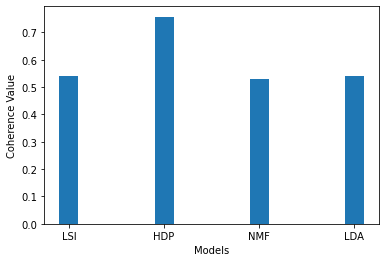

In [25]:
evaluate_bar_graph([coherence_lsi, coherence_hdp, coherence_nmf, coherence_lda],
                   ['LSI', 'HDP', 'NMF','LDA'])
print('\nLSI Coherence Score: ', coherence_lsi)
print('\nHDP Coherence Score: ', coherence_hdp)
print('\nNMF Coherence Score: ', coherence_nmf)
print('\nLDA Coherence Score: ', coherence_lda)